# Modelo de análisis de CVs
El presente archivo presentará la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las carácterísticas predominantes de una HV que hace que avance o no durante el proceso.


### Importar librerías necesarias

In [45]:
from IPython.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar datos

In [46]:
data = pd.read_csv("baseCVs.csv")
#Borramos el nombre de la CV ya que no lo usaremos para nuestro modelo
data = data.drop('CV_Name', axis=1)
data

,Total_Word_Count,Has_Photo,Has_Colors,Pages,Keyword_Count,Education_Exists,Education_Word_Count,Work_Experience_Exists,Work_Experience_Word_Count,Skills_Exists,...,Certifications_Word_Count,Achievements_Exists,Achievements_Word_Count,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed
0,281,0,1,1,8,0,0,0,0,0,...,0,1,63,0,0,1,19,0,0,1
1,336,0,1,2,10,1,15,0,0,1,...,0,0,0,1,51,0,0,0,0,1
2,760,0,1,2,8,1,11,0,0,1,...,0,0,0,1,30,1,35,0,0,1
3,767,1,1,3,11,1,33,1,31,0,...,0,1,12,1,108,0,0,0,0,1
4,482,0,1,2,4,0,0,0,0,0,...,0,1,387,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,630,0,1,4,12,1,5,1,532,1,...,0,0,0,1,6,0,0,0,0,0
302,763,1,1,3,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,1575,1,1,6,8,0,0,1,113,1,...,0,0,0,1,11,0,0,0,0,0
304,372,0,1,2,8,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Descriptivo de la base

In [47]:
def describir_base_datos(data):

    print("Información general de la base de datos:\n")
    print(data.info())

    print("\nEstadísticas descriptivas de las variables numéricas:\n")
    print(data.describe())

    print("\nValores únicos de las variables categóricas:\n")
    for columna in data.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumna: {columna}")
        print(data[columna].unique())

    print("\nFrecuencia de la variable 'Passed':\n")
    print(data['Passed'].value_counts()) # Calcula y muestra las frecuencias de 'target'

    print("\nValores faltantes por columna:\n")
    print(data.isnull().sum())

describir_base_datos(data)

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Total_Word_Count                 306 non-null    int64
 1   Has_Photo                        306 non-null    int64
 2   Has_Colors                       306 non-null    int64
 3   Pages                            306 non-null    int64
 4   Keyword_Count                    306 non-null    int64
 5   Education_Exists                 306 non-null    int64
 6   Education_Word_Count             306 non-null    int64
 7   Work_Experience_Exists           306 non-null    int64
 8   Work_Experience_Word_Count       306 non-null    int64
 9   Skills_Exists                    306 non-null    int64
 10  Skills_Word_Count                306 non-null    int64
 11  Certifications_Exists            306 non-null    int64
 12  Certific

### División de la base en Train y Test

In [48]:
x_train, x_test, y_train, y = train_test_split(data, data['Passed'], test_size=0.3, random_state=69)

print("Forma de x_train:", x_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y:", y.shape)

Forma de x_train: (214, 22)
Forma de x_test: (92, 22)
Forma de y_train: (214,)
Forma de y: (92,)


# Validamos si necesitamos escalado
Inicialmente al usar un modelo basado en árboles no necesitamos escalado.



# Análisis con Random Forest para conseguir prestaciones top baseline

Vamos a realizar una estimación de las prestaciones más precisas que podríamos alcanzar al modelar esta base de datos con aprendizaje automático.

Para ello emplearemos *Random Forest* buscando valores para el número de hojas y el tamaño del bosque.

In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def analizar_random_forest_optimo(data, target_col='Passed', test_size=0.3, random_state=42, cv_splits=3):

    x = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    rf = RandomForestClassifier(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(x_test)
    y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Precisión:", accuracy)
    print("Precisión:", precision)
    print("Recuperación:", recall)
    print("Puntuación F1:", f1)
    print("AUC ROC:", roc_auc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    #Extra#
    feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print("\nRanking de variables por importancia de Random Forest:")
    print(feature_importances)

    return grid_search.best_params_, (accuracy, precision, recall, f1, roc_auc), feature_importances


In [50]:
mejores_params, metrics, ranking_variables = analizar_random_forest_optimo(data)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 900}
Precisión: 0.6086956521739131
Precisión: 0.3333333333333333
Recuperación: 0.058823529411764705
Puntuación F1: 0.1
AUC ROC: 0.563894523326572
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.63      0.93      0.75        58
           1       0.33      0.06      0.10        34

    accuracy                           0.61        92
   macro avg       0.48      0.49      0.42        92
weighted avg       0.52      0.61      0.51        92


Ranking de variables por importancia de Random Forest:
Total_Word_Count                   0.149178
projects_Word_Count                0.121354
Skills_Word_Count                  0.110759
Professional_Profile_Word_Count    0.109864
Education_Word_Count               0.098349
Keyword_Count                      0.088403
Work_Experience_Word_Count         0.079953
Pages                         

In [51]:
from sklearn.feature_selection import mutual_info_classif

def analizar_relevancia_informacion_mutua(dta_ohe, target_col='Passed', test_size=0.3, random_state=42):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_test = mutual_info_classif(x_train, y_train, random_state=random_state)
    feature_scores = pd.Series(f_test, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por información mutua:")
    print(feature_scores)

    plt.figure(figsize=(10, len(feature_scores) * 0.3))
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.title("Información mutua por variable")
    plt.xlabel("Puntuación de información mutua")
    plt.ylabel("Variable")
    plt.show()

    return feature_scores

Ranking de variables por información mutua:
Skills_Word_Count                  0.035906
Professional_Profile_Exists        0.035404
Certifications_Word_Count          0.023186
Education_Word_Count               0.022137
Projects_Exists                    0.021415
volunteer_work_Exists              0.013962
Education_Exists                   0.010966
projects_Word_Count                0.005326
Work_Experience_Word_Count         0.004053
Skills_Exists                      0.000740
Achievements_Exists                0.000000
Professional_Profile_Word_Count    0.000000
Achievements_Word_Count            0.000000
Total_Word_Count                   0.000000
Certifications_Exists              0.000000
Has_Photo                          0.000000
Work_Experience_Exists             0.000000
Keyword_Count                      0.000000
Pages                              0.000000
Has_Colors                         0.000000
volunteer_work_Word_Count          0.000000
dtype: float64


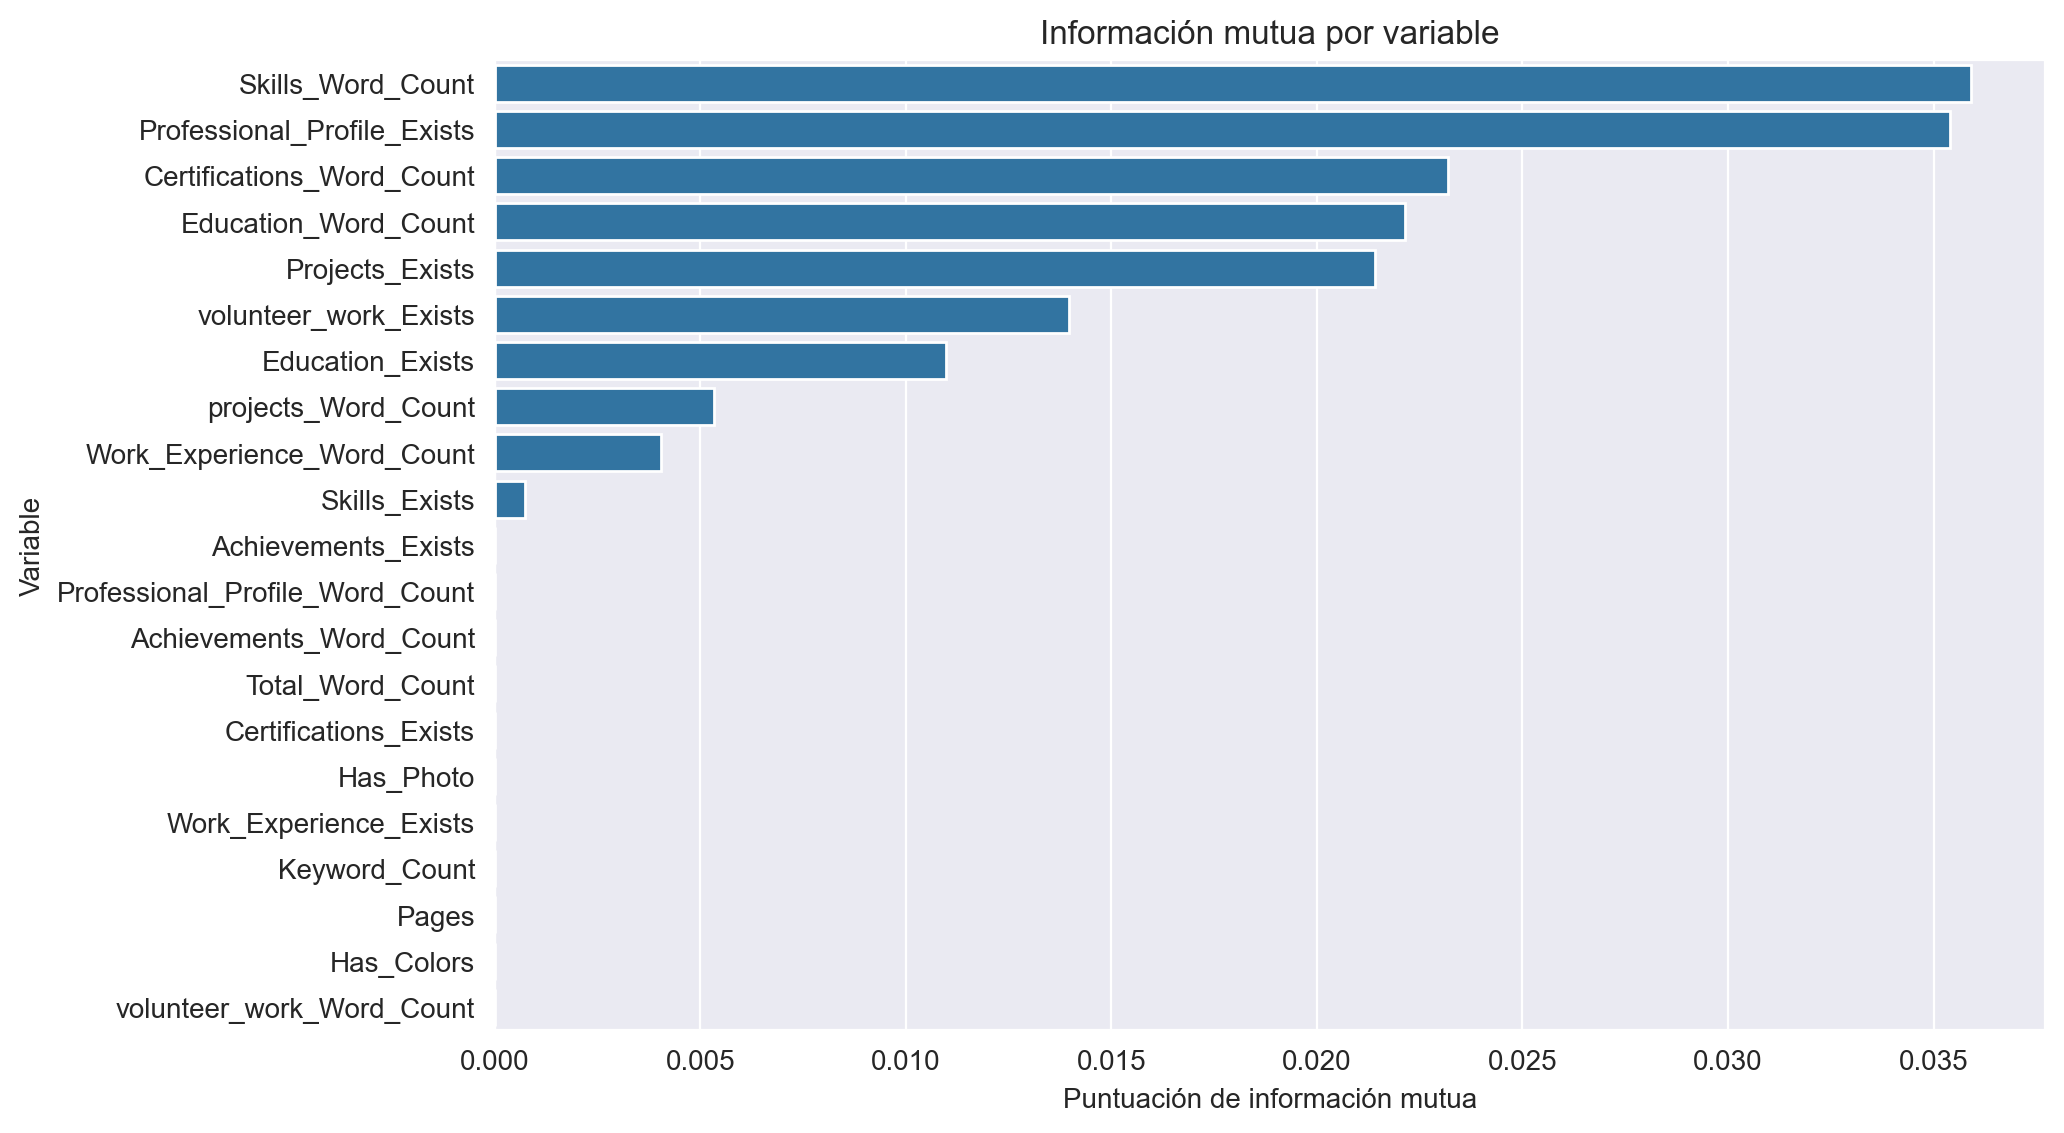

In [52]:
feature_scores = analizar_relevancia_informacion_mutua(data)

## Selección de variables con información mutua y validación cruzada


In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def seleccionar_variables_knn_varias_k(data, target_col='Passed', test_size=0.3, random_state=69, cv_splits=3, k_values=[10, 20, 21]):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    resultados = {}
    for k in k_values:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        param_grid = {
            'knn__n_neighbors': [3, 5, 7, 10, 15],
            'knn__weights': ['uniform', 'distance']
        }

        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
        grid_search.fit(x_train, y_train)

        best_params = grid_search.best_params_
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(x_test)
        y_pred_proba = best_knn.predict_proba(x_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Obtener las variables seleccionadas
        selected_features = x_train.columns[grid_search.best_estimator_.named_steps['select'].get_support()]
        riesgo_entrenamiento = grid_search.score(x_train, y_train)
        riesgo_test = grid_search.score(x_test, y_test)

        resultados[k] = {
            'best_params': best_params,
            'metrics': (accuracy, precision, recall, f1, roc_auc),
            'model': best_knn,
            'selected_features': selected_features  # Agregar las variables seleccionadas
        }

        print(f"Resultados para k={k}:")
        print("Mejores hiperparámetros:", best_params)
        print("Precisión:", accuracy)
        print("Precisión:", precision)
        print("Recuperación:", recall)
        print("Puntuación F1:", f1)
        print("AUC ROC:", roc_auc)
        print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
        print("Acierto en el conjunto de entrenamiento: {0:.2f}(%)".format(100.*riesgo_entrenamiento))
        print("Acierto en el conjunto de test: {0:.2f}(%)".format(100.*riesgo_test))
        print("Variables seleccionadas:", selected_features)  # Imprimir las variables seleccionadas

    return resultados

In [54]:
resultados_knn = seleccionar_variables_knn_varias_k(data)

Resultados para k=10:
Mejores hiperparámetros: {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Precisión: 0.6304347826086957
Precisión: 0.5
Recuperación: 0.29411764705882354
Puntuación F1: 0.37037037037037035
AUC ROC: 0.5732758620689655
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.83      0.74        58
           1       0.50      0.29      0.37        34

    accuracy                           0.63        92
   macro avg       0.58      0.56      0.55        92
weighted avg       0.61      0.63      0.60        92

Acierto en el conjunto de entrenamiento: 63.55(%)
Acierto en el conjunto de test: 63.04(%)
Variables seleccionadas: Index(['Total_Word_Count', 'Has_Colors', 'Education_Exists',
       'Work_Experience_Exists', 'Achievements_Exists',
       'Achievements_Word_Count', 'Professional_Profile_Exists',
       'Professional_Profile_Word_Count', 'Projects_Exists',
       'projects_Word_Count'],
      dtype='ob

## Agregar variables al modelo


In [55]:
def agregar_variables_recursivamente(data, target_col='Passed', test_size=0.3, random_state=42):
    """
    Agrega variables al modelo recursivamente y grafica la precisión.

    Args:
        dta_ohe (pd.DataFrame): DataFrame con variables codificadas one-hot.
        target_col (str): Nombre de la columna objetivo.
        test_size (float): Tamaño del conjunto de prueba.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        tuple: Orden de variables añadidas y lista de precisiones en prueba.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = []
    for _ in range(X.shape[1]):
        mejores_variables = []
        mejor_precision = 0

        variables_restantes = [col for col in X.columns if col not in variables_actuales]
        for variable in variables_restantes:
            variables_prueba = variables_actuales + [variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                mejores_variables = variables_prueba + []

        variables_actuales = mejores_variables
        orden_variables.append(variables_actuales[-1])
        precisiones_test.append(mejor_precision)

    print("Orden de variables añadidas:", orden_variables)

    plt.plot(range(1, len(precisiones_test) + 1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables añadidas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables añadidas: ['Professional_Profile_Word_Count', 'Has_Photo', 'Education_Exists', 'Professional_Profile_Exists', 'Projects_Exists', 'volunteer_work_Word_Count', 'Skills_Exists', 'volunteer_work_Exists', 'Has_Colors', 'Certifications_Word_Count', 'Certifications_Exists', 'Achievements_Word_Count', 'Skills_Word_Count', 'Work_Experience_Word_Count', 'Education_Word_Count', 'Work_Experience_Exists', 'Achievements_Exists', 'Pages', 'Keyword_Count', 'projects_Word_Count', 'Total_Word_Count']


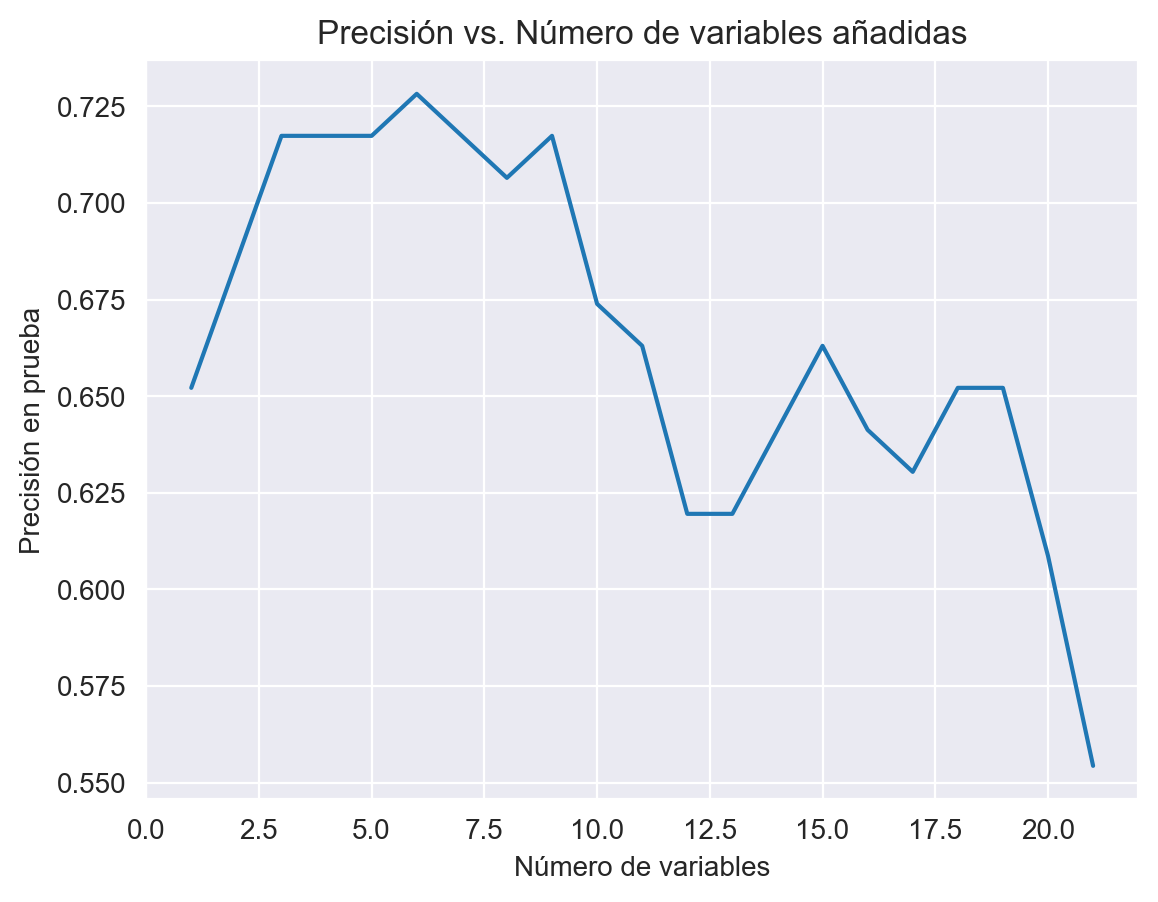

In [56]:
orden_vars, precisiones = agregar_variables_recursivamente(data)


Eliminar Variables del modelo

In [57]:
def eliminar_variables_recursivamente(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = list(X.columns)
    while len(variables_actuales) > 1:
        peor_variable = None
        mejor_precision = 0

        for variable in variables_actuales:
            variables_prueba = [v for v in variables_actuales if v != variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                peor_variable = variable

        variables_actuales.remove(peor_variable)
        orden_variables.append(peor_variable)
        precisiones_test.append(mejor_precision)

    print("Orden de variables eliminadas:", orden_variables)

    plt.plot(range(len(precisiones_test), 0, -1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables eliminadas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables eliminadas: ['Total_Word_Count', 'Professional_Profile_Exists', 'Education_Word_Count', 'Achievements_Exists', 'Keyword_Count', 'Has_Colors', 'Projects_Exists', 'volunteer_work_Exists', 'volunteer_work_Word_Count', 'Certifications_Exists', 'Work_Experience_Exists', 'Education_Exists', 'Professional_Profile_Word_Count', 'Pages', 'Achievements_Word_Count', 'Skills_Exists', 'projects_Word_Count', 'Skills_Word_Count', 'Work_Experience_Word_Count', 'Has_Photo']


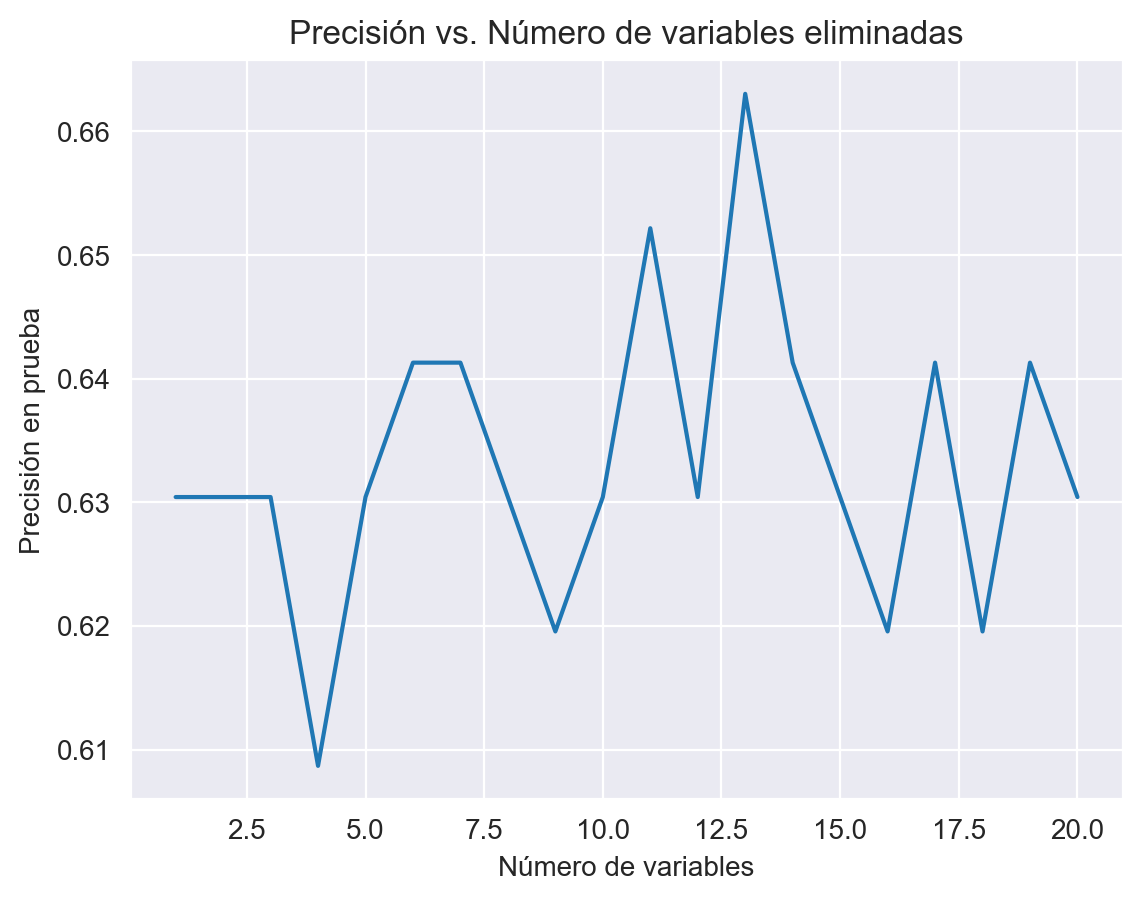

In [58]:
orden_vars, precisiones = eliminar_variables_recursivamente(data)

## Ranking de variables

In [59]:
def obtener_importancia_rf(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    model = RandomForestClassifier(random_state=random_state)
    model.fit(x_train, y_train)

    feature_importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por importancia de Random Forest:")
    print(feature_importances)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title("Importancia de variables de Random Forest")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()

    return feature_importances


Ranking de variables por importancia de Random Forest:
Total_Word_Count                   0.141408
Skills_Word_Count                  0.115632
Education_Word_Count               0.109005
Keyword_Count                      0.108143
Professional_Profile_Word_Count    0.102512
projects_Word_Count                0.083897
Pages                              0.071693
Work_Experience_Word_Count         0.052900
Certifications_Word_Count          0.036480
Has_Photo                          0.029727
Achievements_Word_Count            0.023805
Professional_Profile_Exists        0.020363
Work_Experience_Exists             0.018834
Projects_Exists                    0.018187
Skills_Exists                      0.015556
Certifications_Exists              0.015269
Education_Exists                   0.011566
Achievements_Exists                0.011023
Has_Colors                         0.005035
volunteer_work_Word_Count          0.004864
volunteer_work_Exists              0.004100
dtype: float64


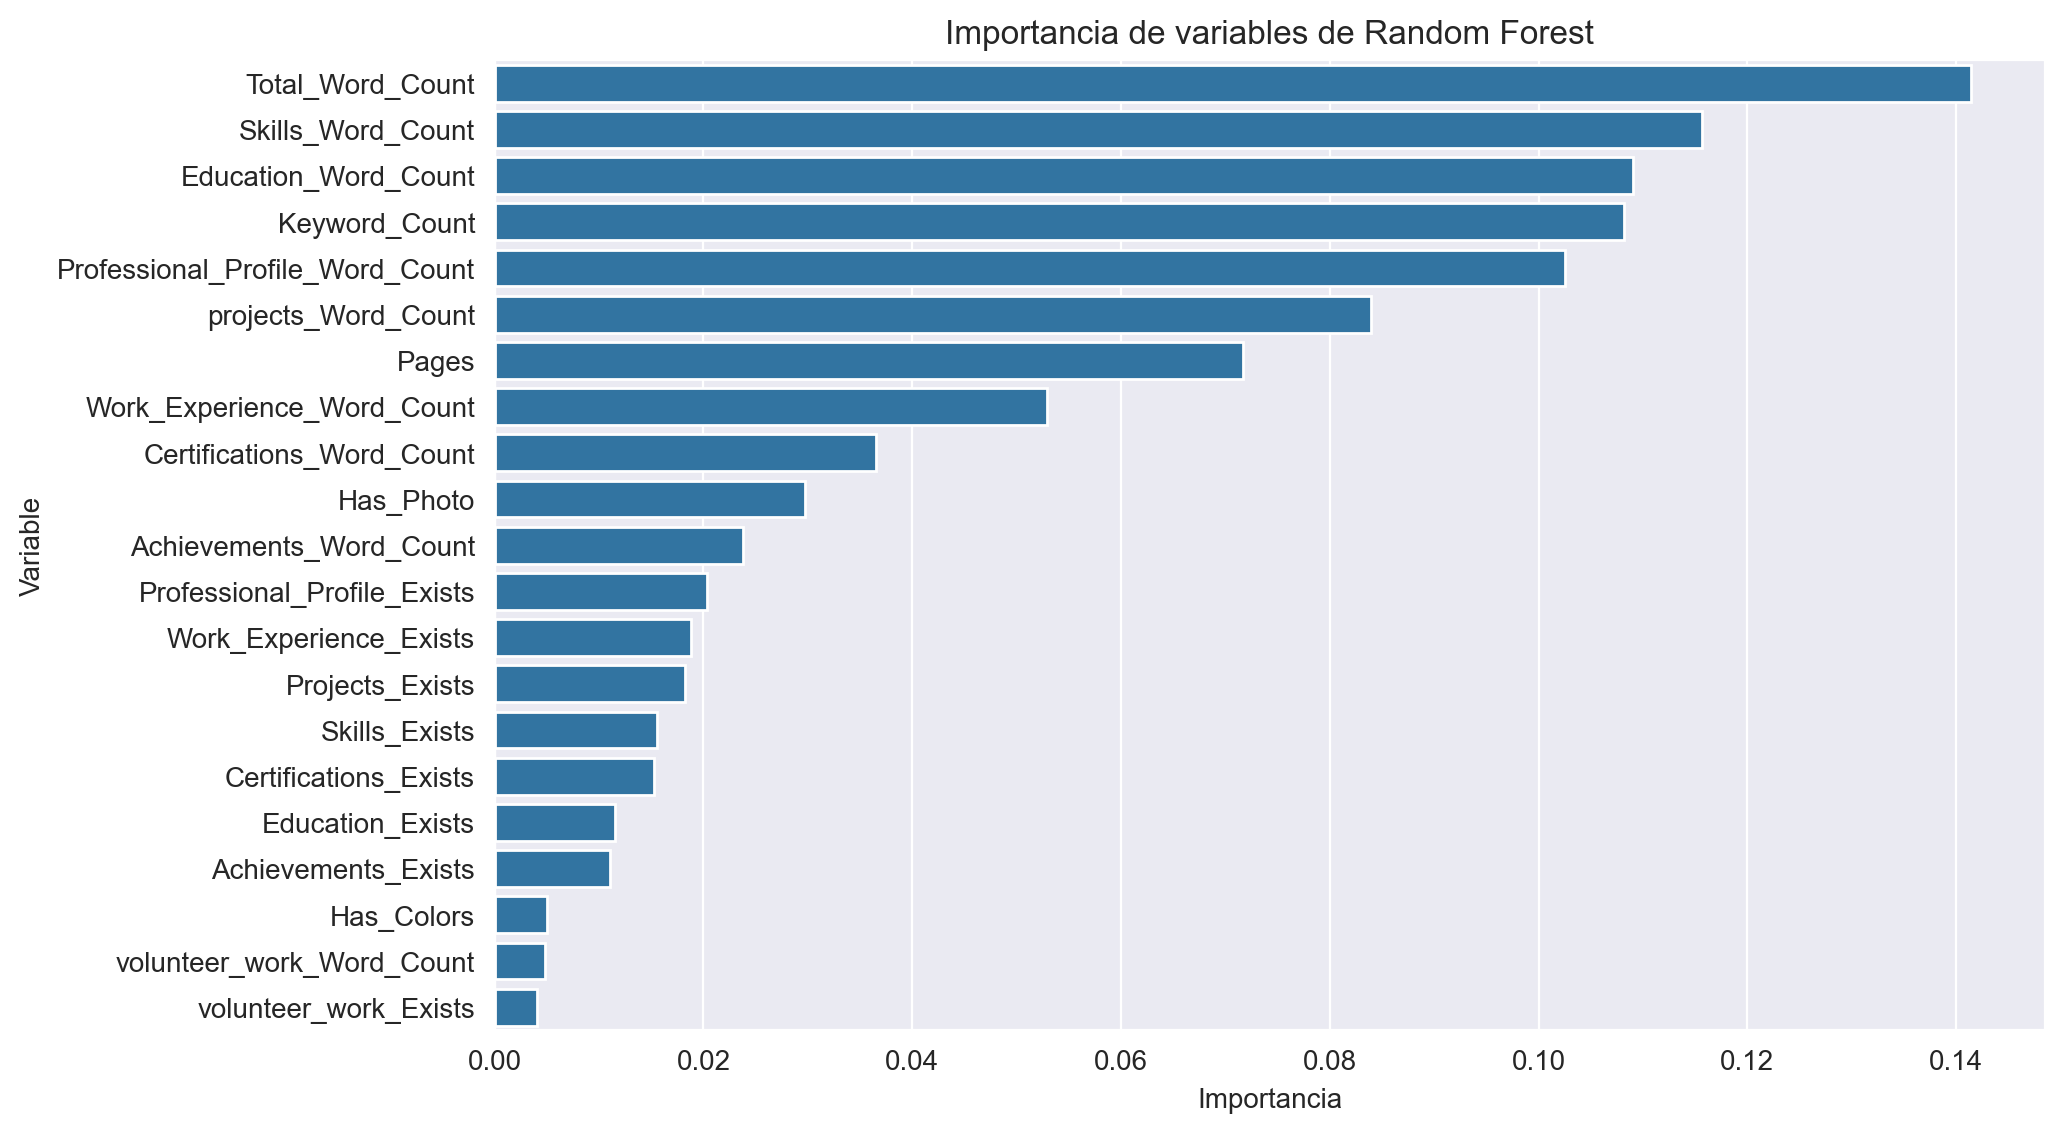

In [60]:
importancia_rf = obtener_importancia_rf(data)